In [1]:
using NCDatasets
#import Pkg; Pkg.add("NCDatasets")
using PyCall
pushfirst!(pyimport("sys")."path", "");
pyTables = pyimport("lkTables")
pyTables_=pyTables.scattTables()


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 


PyObject <lkTables.scattTables object at 0x13feec640>

In [3]:
include("juliaScattTables.jl")
scatt_tables = scattTables(pyTables_);


In [139]:
function hb(zKum, alpha, beta, dr, srt_piaKu)
    q = 0.2 * log(10)
    zeta = q * beta * alpha * 10.0 .^(0.1 * zKum * beta) * dr
    zetamax = 1.0 - 10.0^(-srt_piaKu / 10 * beta)
    
    if sum(zeta) > zetamax
        eps = 0.9999 * zetamax / sum(zeta)
    else
        eps = 1.0
    end
    corrc = eps * cumsum(zeta)
    dpia= -10.0 ./ beta * log10.(1.0 .- corrc)
    zc = zKum .+ dpia
    return zc, eps, -10 / beta * log10(1 - corrc[end])
end


hb (generic function with 1 method)

In [140]:

function hbvect(zKum, alpha, beta, dr, srt_piaKu)
    q = 0.2 * log(10)
    zeta = q * beta * alpha .* 10.0 .^(0.1 * zKum * beta) * dr
    zetamax = 1.0 - 10.0^(-srt_piaKu / 10 * beta)
    
    if sum(zeta) > zetamax
        eps = 0.9999 * zetamax / sum(zeta)
    else
        eps = 1.0
    end
    corrc = eps * cumsum(zeta)
    dpia= -10.0 ./ beta * log10.(1.0 .- corrc)
    zc = zKum .+ dpia
    return zc, eps, -10 / beta * log10(1 - corrc[end])
end

hbvect (generic function with 1 method)

In [6]:
alpha_nom=10^(-3.199)
beta_nom=0.71
zKum=[35.,34.,32.,33.,31.0]
zKum=42.0:-0.5:25.0
dr=0.125
print(size(zKum))

(35,)

In [ ]:
zKum=42.0:-0.5:25.0

In [388]:

srt_piaKu=30
zKuF,eps,PIA=hb(zKum, alpha_nom, beta_nom, dr, srt_piaKu)
NwCoeff = [-7.07747934, 4.63232708]
println(PIA)
function invNw(Dm)
    return NwCoeff[2] + NwCoeff[1] * log10(Dm)-3.9
end
println(invNw(1.0))

2.1630473517117546
0.7323270799999997


In [8]:
function bisectm(xvec, nv, r)
    n1 = 1
    n2 = nv
    if r < xvec[1]
        return 1
    end
    if r >= xvec[n2]
        return nv
    end
    nmid = div(n1 + n2, 2)
    it = 0
    while !(r >= xvec[nmid] && r < xvec[nmid + 1]) && it < 7
        it += 1
        if r > xvec[nmid]
            n1 = nmid
        else
            n2 = nmid
        end
        nmid = div(n1 + n2, 2)
    end
    return nmid
end

bisectm (generic function with 1 method)

In [106]:

#piaBinL=[]
#@time for i in 1:10000
#    piaBin = 0.0
#    dnp = 0.0
#    alpha_dnw = []
#    dNwBin = []
#    for k in 1:35
#        ibin = bisectm(scatt_tables.zKuR[1:289], 289, zKuF[k])
#        piaBin += scatt_tables.attKuR[ibin] * dr * 2
#        dmBin = scatt_tables.dmr[ibin]
#    end
#    push!(piaBinL,piaBin)
#end
#print(piaBinL[1],' ',piaBinL[end])

function fromhb(zKuF,scatt_tables,dr,dn)
    
    piaBin = 0.0
    dnp = 0.0
    nbins=size(zKuF)[1]
    dmRet=Vector{Float64}(undef,nbins)
    pRateRet=Vector{Float64}(undef,nbins)
    zKaSim=Vector{Float64}(undef,nbins)
    attKu1D=Vector{Float64}(undef,nbins)
    attKa1D=Vector{Float64}(undef,nbins)
    piaKa=0
    for k in 1:nbins
        ibin = bisectm(scatt_tables.zKuR[1:289], 289, zKuF[k]-10*dn)
        attKu1D[k]=scatt_tables.attKuR[ibin] *10.0^(dn)
        piaBin += scatt_tables.attKuR[ibin] * dr * 2*10.0^(dn)
        dmBin = scatt_tables.dmr[ibin]
        pRateRet[k] = scatt_tables.rainRate[ibin]*10.0^(dn)
        dmRet[k] = dmBin
        attKa= scatt_tables.attKaR[ibin]*10.0^(dn)
        attKa1D[k]=attKa
        piaKa+=attKa*dr
        zKaSim[k] = scatt_tables.zKaR[ibin]+10*dn-piaKa
        piaKa+=attKa*dr
    end
     
    return piaBin,dmRet,pRateRet,zKaSim,attKu1D,attKa1D
end

fromhb (generic function with 2 methods)

In [158]:
readStormData=pyimport("readStormData")
zMeas,bcf,bsfc,bzd,pFlag,reliabF,pType,zFactorF,PIAhybrid,dm,pRateCMB=readStormData.readStormData();

In [159]:
println(size(pRateCMB))

(744, 49, 88)


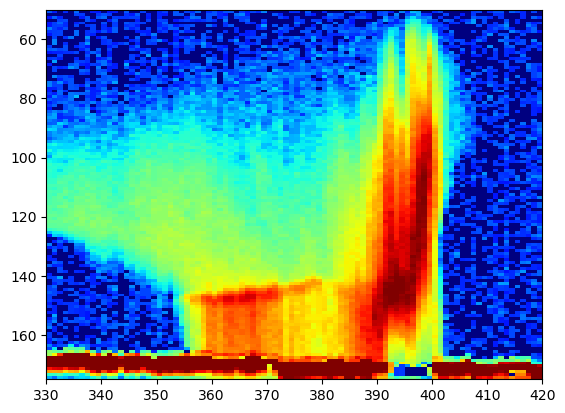

(330.0, 420.0)

In [33]:
# import matplotlib
using PyPlot
#plt=pyimport("matplotlib.pyplot")
pcolormesh(transpose(zMeas[:,25,:,1]),vmin=0,vmax=50,cmap="jet")
ylim(175,50)
xlim(330,420)
#plt.show()

-0.04993060059101664

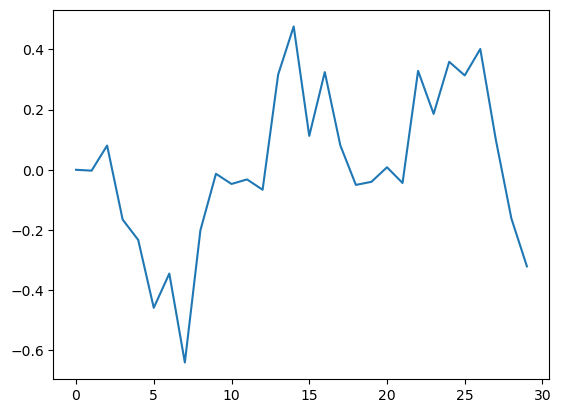

fromhbvect (generic function with 2 methods)

In [473]:
using Random, Distributions
ndist=Normal(0.0,1.0)
function ou_process(nsteps,theta,sigma,ndist)
    x=Vector{Float64}(undef,nsteps)
    x[1]=0.0
    for i in 2:nsteps
        x[i]=x[i-1]+theta*(0-x[i-1])+sigma*rand(ndist)
    end
    return x
end
print(rand(ndist))
x=ou_process(30,0.2,0.2,ndist)
plot(x)

function fromhbvect(zKuF,scatt_tables,dr,dn,piaKuTop,piaKaTop)
    
    piaBin = 0.0
    nbins=size(zKuF)[1]
    dmRet=Vector{Float64}(undef,nbins)
    pRateRet=Vector{Float64}(undef,nbins)
    zKaSim=Vector{Float64}(undef,nbins)
    attKu1D=Vector{Float64}(undef,nbins)
    attKa1D=Vector{Float64}(undef,nbins)
    piaKa=piaKaTop
    for k in 1:nbins
        ibin = bisectm(scatt_tables.zKuR[1:289], 289, zKuF[k]-10*dn[k])
        attKu1D[k]=scatt_tables.attKuR[ibin] *10.0^(dn[k])
        piaBin += scatt_tables.attKuR[ibin] * dr * 2*10.0^(dn[k])
        dmBin = scatt_tables.dmr[ibin]
        pRateRet[k] = scatt_tables.rainRate[ibin]*10.0^(dn[k])
        dmRet[k] = dmBin
        attKa= scatt_tables.attKaR[ibin]*10.0^(dn[k])
        attKa1D[k]=attKa
        piaKa+=attKa*dr
        zKaSim[k] = scatt_tables.zKaR[ibin]+10*dn[k]-piaKa
        piaKa+=attKa*dr
    end
    #zKaSim=zKaSim.-attKa1D[1].*0.5
    piaBin=piaBin+piaKuTop
    return piaBin,dmRet,pRateRet,zKaSim,attKu1D,attKa1D
end

In [153]:
zKum=42.0:-0.5:25.0
dn1d=ou_process(size(zKum)[1],0.15,0.2,ndist);
dn_mean=-0.5+0.5*rand(ndist);
dn=dn_mean.+dn1d;

dalpha=10.0.^((dn)*(1-beta_nom));
#println(dalpha.*alpha_nom)
zKuF,eps,PIA1=hbvect(zKum, dalpha.*alpha_nom, beta_nom, dr, srt_piaKu);
piaBin,dmRet,pRateRet,zKaSim,attKu1D,attKa1D=fromhbvect(zKuF,scatt_tables,dr,dn);

In [266]:
using Statistics
using LinearAlgebra
function kalmanf(X, X2, Y, yobs, sigZ)
    # System dimensions
    nx = size(X, 1)
    ny = size(Y, 1)
    X=log.(1.0.+X./10.0)
    # Covariance matrices using broadcasting
    covXY = cov(X', Y')
    covX2Y = cov(X2', Y')
    covYY = cov(Y',Y') + sigZ .* Matrix{Float64}(I, ny, ny) 

    # Pseudoinverse using QR decomposition (more stable than pinv)
    
    invCovYY = pinv(covYY)
    #println(size(invCovYY))
    #println(size(covXY))
    # Kalman gain
    kgain = covXY * invCovYY
    kgain2 = covX2Y * invCovYY

    # Mean of observation vector and adjusted measurement
    ymean = mean(Y, dims=2)
    #ymean = ymean .- ymean[1]
    #yobs_adj= yobs .- yobs[1]
    dy = Float64.(yobs) - ymean
    

    # Apply threshold using logical indexing
    thresholded_dy = dy
    for i in 1:ny
        if yobs[i] < 10.0
            thresholded_dy[i] = 0
        end
    end

    # Mean of state vector and state estimate
    xmean = mean(X, dims=2)
    x2mean = mean(X2, dims=2)   
    xest = xmean + kgain * thresholded_dy
    x2est = x2mean + kgain2 * thresholded_dy
    xest=10.0.*(exp.(xest).-1.0)
    return xest,x2est
end

kalmanf (generic function with 3 methods)

In [500]:
pia1L=[]
pia2L=[]
zKa1L=[]
zKa2L=[]
zKu1L=[]
piau=[]
attKuTopL=[]
attKaTopL=[]
nMemb=120
pRateSfcL=[]
pRateSfcCMBL=[]
dnwL=[]
dmL=[]
piaHybL=[]
piaKFL=[]
zKaSimL=[]
zKaSimKFL=[]
zKaMeasL=[]
for jray in 13:37
    for i=358:388
        if div(pType[i,jray]/1e7,1)==1
            srt_piaKu=max(30.0,55.0-Float64(zMeas[i,jray,bcf[i,jray],1]))
            zku1=(zMeas[i,jray,bzd[i,jray]+6:bcf[i,jray],1])
            piaKuTop=0.8*(zFactorF[i,jray,bzd[i,jray]+5,1]-zMeas[i,jray,bzd[i,jray]+5,1])
            if piaKuTop<0
                piaKuTop=0
            end
            if piaKuTop>2
                println("piaKuTopLarge=",piaKuTop)
                piaKuTop=2

            end
            #println(piaKuTop)
            zku1=zku1.+piaKuTop
            piaKaTop=piaKuTop*6
            nbins=size(zku1)[1]
            zKaEns=Array{Float64}(undef,nbins,nMemb)
            piaKaEns=Array{Float64}(undef,nMemb)
            piaKuEns=Array{Float64}(undef,nMemb)
            dnEns=Array{Float64}(undef,nbins,nMemb)
            pRateRetEns=Array{Float64}(undef,nbins,nMemb)
            bcfCMB=div(bcf[i,jray,1],2)
            push!(pRateSfcCMBL,pRateCMB[i,jray,bcfCMB-1])
            for imemb in 1:nMemb
                nbins=size(zku1)[1]
                PIA1=-999.0
                it=0
                while abs(PIA1-PIAhybrid[i,jray,1])>1 && it<1
                    dn1d=ou_process(nbins,0.1,0.35,ndist)
                    dn_mean=-0.25+0.35*rand(ndist)
                    dn=dn_mean.+0.65*dn1d
                    dalpha=10.0.^((dn)*(1-beta_nom))
                    zKuF,eps,PIA1=hbvect(zku1, dalpha.*alpha_nom, beta_nom, dr, srt_piaKu)
                    it+=1
                end
                dnEns[:,imemb]=dn
                piaBin,dmRet,pRateRet,zKaSim,attKu1D,attKa1D=fromhbvect(zKuF,scatt_tables,dr,dn)
                for i in 1:nbins
                    if dmRet[i]>0.5 && dmRet[i]<2.0
                        if dmRet[i]>1.0
                            dn[i]+=0.5*invNw(dmRet[i])
                        else
                            dn[i]+=0.5*invNw(dmRet[i])
                        end
                    end
                end
                dalpha=10.0.^((dn)*(1-beta_nom))
                zKuF,eps,PIA1=hbvect(zku1, dalpha.*alpha_nom, beta_nom, dr, srt_piaKu)
                piaBin,dmRet,pRateRet,zKaSim,attKu1D,attKa1D=fromhbvect(zKuF,scatt_tables,dr,dn,piaKuTop,piaKaTop)
                zKaEns[:,imemb]=zKaSim
                piaKaEns[imemb]=sum(attKa1D)*dr*2
                piaKuEns[imemb]=sum(attKu1D)*dr*2
                pRateRetEns[:,imemb]=pRateRet
            

            #push!(attKuTopL,attKu1D[1])
            #push!(attKaTopL,attKa1D[1])
            #println(i,' ',div(pType[i,25]/1e7,1),size(zku1)[1],' ',PIA1)
            #push!(piau,zFactorF[i,25,bzd[i,25]+6,2]-zMeas[i,25,bzd[i,25]+6,2])
            #push!(pia1L,PIA1)
            #push!(pia2L,PIAhybrid[i,25,1])
            #push!(zKa1L,[zKaSim[1],zKaSim[end]])
            #push!(zKa2L,[zMeas[i,25,bzd[i,25]+6],zMeas[i,25,bcf[i,25],2]])
            #push!(zKu1L,zku1[end])
            end
            yobs=zMeas[i,jray,bzd[i,jray]+6:bcf[i,jray],2]
            sigZ=1.5^2
            pRateKF,dnKF=kalmanf(pRateRetEns, dnEns, zKaEns, yobs, sigZ)
            if pRateKF[end]>30
                println("pRateKF=",pRateKF[end],' ',i,' ',jray)
            end
            #print(size(dnKF))
            dalphaKF=10.0.^((dnKF[:,1])*(1-beta_nom))
            #println(zku1)
            zKuKFF,epsF,PIA1F=hbvect(zku1, dalphaKF.*alpha_nom, beta_nom, dr, srt_piaKu)
            piaBinKF,dmRetKF,pRateRetKF,zKaSimKF,attKu1DKF,attKa1DKF=fromhbvect(zKuKFF,scatt_tables,dr,dnKF)
        #println(size(pRateKF))
            push!(pRateSfcL,pRateRetKF[end])
            if PIAhybrid[i,jray,1]>0
                push!(piaHybL,PIAhybrid[i,jray,1])
                push!(piaKFL,piaBinKF+attKu1DKF[end]*dr*(bsfc[i,jray,1]-bcf[i,jray,1])*2)
            end
            zKaSimM=mean(zKaEns,dims=2)
            for k in 1:nbins
                push!(dnwL,dnKF[k,1])
                push!(dmL,dmRetKF[k])
                if zMeas[i,jray,bzd[i,jray]+6+k,2]>10.0
                    push!(zKaMeasL,zMeas[i,jray,bzd[i,jray]+6+k,2])
                    push!(zKaSimKFL,zKaSimKF[k])
                    push!(zKaSimL,zKaSimM[k])
                end
            end
            
        end
    end
end

np=pyimport("numpy")
#println(np.corrcoef(pia1L,pia2L))
#zKa1L=Float64.(zKa1L)
#zKa2L=Float64.(zKa2L)
#println(np.mean(pia1L),' ',np.mean(pia2L))

PyObject <module 'numpy' from '/Users/mgrecu/miniconda3/lib/python3.9/site-packages/numpy/__init__.py'>

[1.0 0.626795934464332; 0.626795934464332 1.0]
1.1288071739834986 1.43579
[1.0 0.6946284412028549; 0.6946284412028549 1.0]
[1.0 0.8641776627451719; 0.8641776627451719 1.0]


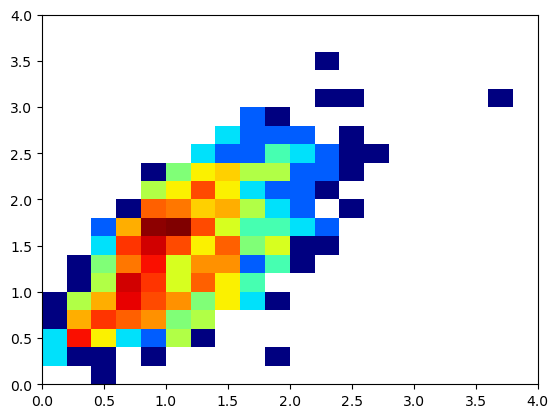

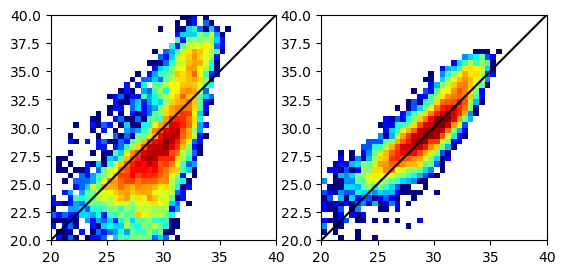

(20.0, 40.0)

In [501]:
println(np.corrcoef(piaKFL,piaHybL))
#scatter(piaKFL,piaHybL)
plt.hist2d(piaKFL,piaHybL,bins=0:0.2:4,cmap="jet",norm=mp.colors.LogNorm());
println(mean(piaKFL)," ",mean(piaHybL))
println(np.corrcoef(zKaMeasL,zKaSimL))
println(np.corrcoef(zKaMeasL,zKaSimKFL))
figure()
ax1=subplot(1,2,1)
mp=pyimport("matplotlib")
h1=plt.hist2d(zKaMeasL,zKaSimL,bins=20:0.5:40,cmap="jet",norm=mp.colors.LogNorm());

plot([20,40],[20,40],"k")
ax1.set_aspect("equal")
xlim(20,40)
ylim(20,40)
ax2=subplot(1,2,2)
plt.hist2d(zKaMeasL,zKaSimKFL,bins=20:0.5:40,cmap="jet",norm=mp.colors.LogNorm());
plot([20,40],[20,40],"k")
ax2.set_aspect("equal")
xlim(20,40)
ylim(20,40)

[0.9999999999999999 0.6373018048373624; 0.6373018048373624 0.9999999999999998]
3.9057632652136847 4.963272930494898


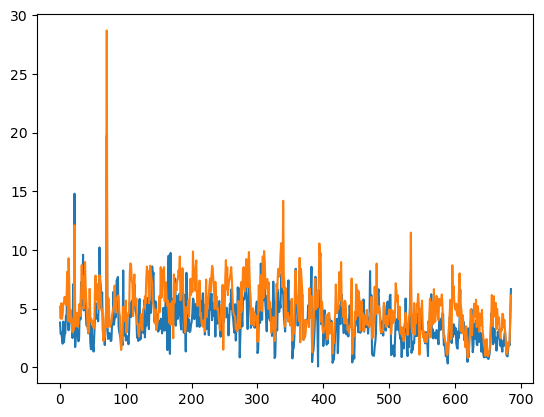

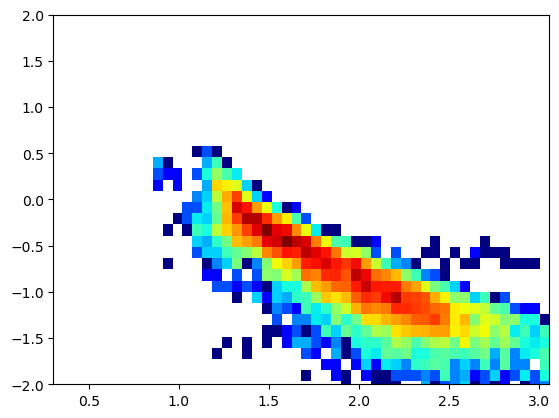

(-2.0, 2.0)

In [502]:
#scatter(pRateSfcL,pRateSfcCMBL)
plot(pRateSfcL)
plot(pRateSfcCMBL)
println(np.corrcoef(pRateSfcL,pRateSfcCMBL))
println(np.mean(pRateSfcL)," ",np.mean(pRateSfcCMBL))
plt.figure()
plt=pyimport("matplotlib.pyplot")
histD=plt.hist2d(dmL,dnwL,bins=50,norm=matplotlib.colors.LogNorm(),cmap="jet")
ylim(-2,2)

In [466]:
println(size(pRateSfcL))

(686,)


In [120]:
using Random, Distributions
d=Normal(0.0,1.0)


1.0

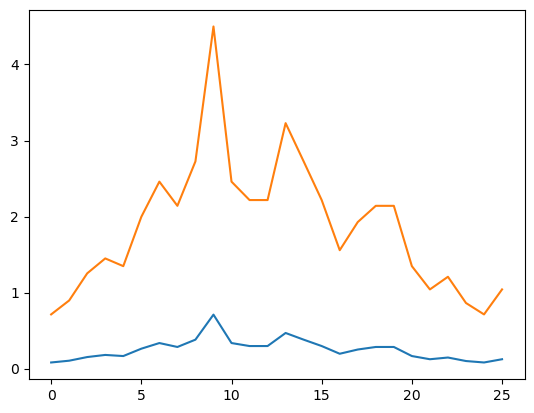

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x303920b50>

In [109]:
piau=np.array(piau)
plot(attKuTopL)
plot(attKaTopL)
#plt.plot(piau)

(26, 2)

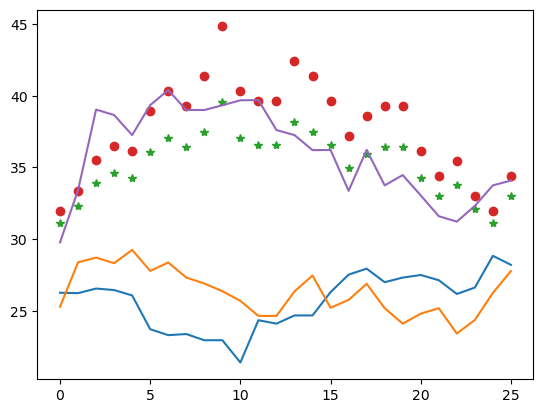

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3037a20a0>

In [101]:
zKa1L=np.array(zKa1L,dtype=np.float64);
zKa2L=np.array(zKa2L,dtype=np.float64);
print(size(zKa1L))
plot(zKa1L[:,2])
plot(zKa2L[:,2])
plot(zKa1L[:,1],"*")
plot(zKa2L[:,1],"o")
plot(zKu1L[:])

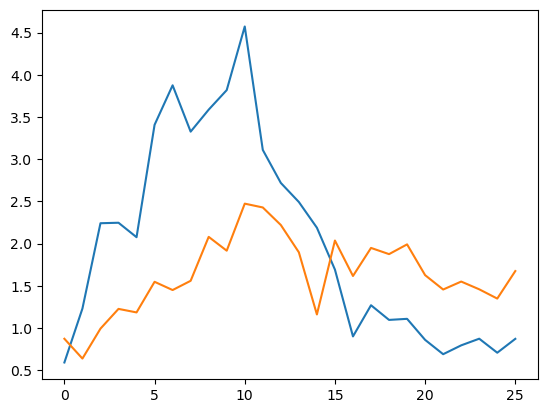

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2fc790f70>

In [71]:
plot(pia1L)
plot(pia2L)